In [1]:
import math
from typing import Literal
import numpy as np
import pandas as pd

class DataPreprocessor:

    def __init__(self):
        pass

    def pipeline(self, df, copy: bool = False):
        if copy:
            df = df.copy()
        df['Last Updated'] = pd.to_datetime(df['Last Updated'])
        self.drop_outdated(df)
        df['Category'] = pd.Categorical(df['Category'])
        self.to_bytes(df, 'Size')
        self.estimate_size(df)
        self.genre_cleaning(df)
        df['Genres'] = pd.Categorical(df['Genres'])
        df['Size'] = df['Size'].astype('Int32')
        self.installs_cleaning(df)
        self.price(df)
        self.rating_fillna(df)
        self.reviews_to_int(df)
        self.drop_na_values(df)
        df.drop(columns=['Current Ver', 'Android Ver'], inplace=True)

        return df

    def drop_outdated(self, df):
        # Drop outdated data by sorting by date and keeping the last entry
        df.sort_values(by='Last Updated', inplace=True)

        df.drop_duplicates(
            subset = ['App', 'Rating', 'Size', 'Installs', 'Type',
                'Price', 'Content Rating', 'Genres', 'Current Ver',
                'Android Ver'], # Ignoring 'Reviews', 'Category', and 'Last Updated'
            keep = 'last', # The last entry is also the most recent one 
            inplace = True)

    def item_to_bytes(self, item):
        # Convert the item into multiplying the value for the corresponding
        # multiplier based on the simbol. If the value in not recognised it's
        # return without alteration
        if item.isdigit():
            return int(item)
        elif item[-1] == 'k':
            return int(float(item[:-1]) * 1_024) 
        elif item[-1] == 'M':
            return int(float(item[:-1]) * 1_024 * 1_024) 
        else:
            return item

    def to_bytes(self, df, column):
        # Convert the entire column to bytes
        df[column] = df[column].apply(self.item_to_bytes)

    def estimate_size(self, df):
        # Estimate the average size of every category based on the avilable data and use it to fill the missing value.
        # Can handle np.nan and 'Varies with device'
        categories_mean_size = {}

        for category in df['Category'].unique():
            category_mean = df.loc[(df['Category'] == category) & (df['Size'] != 'Varies with device'), 'Size'].mean()
            categories_mean_size[category] = math.floor(category_mean)

        for category in df['Category'].unique():
            df.loc[(df['Category'] == category) & (df['Size'] == 'Varies with device'), 'Size'] = categories_mean_size[category]
            df.loc[df['Size'].isna(), 'Size'] = categories_mean_size[category]

    def genre_cleaning(self, df):
        # If the genre is composed by two genres, keep only the first one
        df['Genres'] = df['Genres'].str.split(';', expand=True)[0]

    def size_to_int(self, df):
        # Casting size column in integer type 
        df['Size'] = df['Size'].astype('Int32')

    def installs_cleaning(self, df):
        # Extracting numerical values from original column and then concatenating them back together leaving out
        # non numerical digits, and finally casting into integer type 
        df['Installs'] = df['Installs'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
        
    def price(self, df):
        # Replacing $ sign with empty and casting values in float type
        df['Price'] = np.array([value.replace('$', '') for value in df['Price']]).astype(float)
        
    def rating_fillna(self, df):
        ## replacing nan values with mean of the column 
        mean = df['Rating'].dropna().mean()
        df['Rating'].fillna(mean, inplace=True)
        
    def reviews_to_int(self, df):
        # Casting reviews column in integer type 
        df['Reviews'] = df['Reviews'].astype('Int32')

    def drop_na_values(self, df):
        # Dropping Nan value(s) left
        if df.isna().sum().any()>0:
            df.dropna(inplace=True)

In [2]:
df=pd.read_csv('googleplaystore.csv')

In [3]:
df.loc[df['App'] == 'Life Made WI-Fi Touchscreen Photo Frame', ['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']] = np.NaN, 1.9, '19', '3.0M', '1,000+', 'Free', '0', 'Everyone', np.NaN, 'February 11, 2018', '1.0.19', '4.0 and up'
df.loc[df['App'] == 'Life Made WI-Fi Touchscreen Photo Frame', ['Category', 'Genres']] = 'LIFESTYLE', 'Lifestyle'

dp = DataPreprocessor()

In [4]:
df = dp.pipeline(df)

## Tasks week 15 :
#1.print(table) the unique names of all categories

#2.plot a bar chart for categories with the total number of installing numbers in each category 

#3.plot a bar chart for the total prices of each paid app in each category ( the sum of all prices in the same category)

#4.plot a bar chart of the total revenue of each category by multiplying the price by the number of installs

In [5]:
import matplotlib.pyplot as plt

In [6]:
s0=df[['Category','Installs']].groupby(by='Category').sum()

In [7]:
s0v0=s0.values.reshape(len(s0))/10**8

In [8]:
s0.sort_values('Installs',inplace=True)

<BarContainer object of 33 artists>

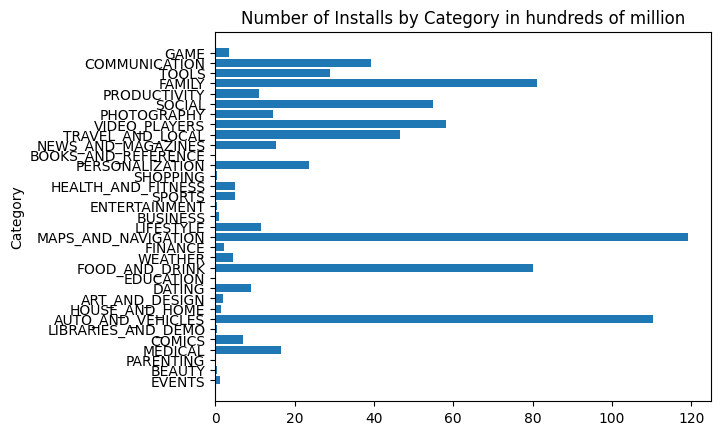

In [9]:
plt.ylabel('Category')
plt.title('Number of Installs by Category in hundreds of million')
plt.barh(s0.index,s0v0)

In [10]:
s1=df.loc[df['Price']>0][['Category','Price']].groupby(by='Category').sum()

In [11]:
s1.sort_values('Price',inplace=True)

<BarContainer object of 33 artists>

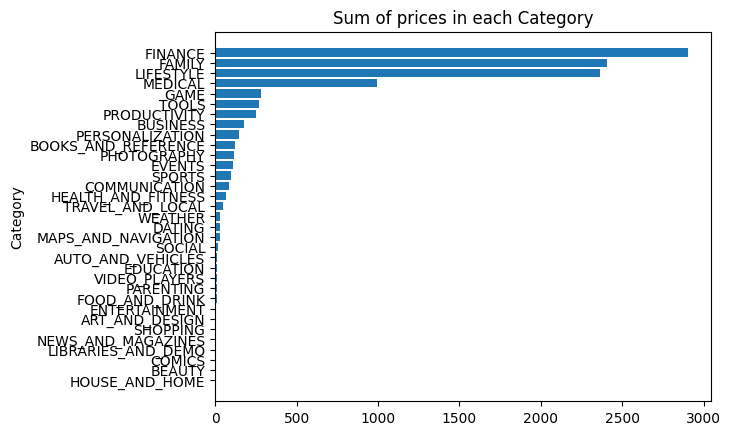

In [12]:
plt.ylabel('Category')
plt.title('Sum of prices in each Category')
plt.barh(s1.index,s1.values.reshape(len(s1)))

In [69]:
s2=df.loc[df['Price']>0][['Category','Installs']].groupby(by='Category').sum()

In [83]:
## rescaling
s2=s2/10**6

In [84]:
s1_s2=s2.multiply(s1.values)

In [85]:
s1_s2.rename(columns={'Installs':'Total revenues by Category'},inplace=True)

In [86]:
s1_s2.sort_values(by='Total revenues by Category',inplace=True)

<BarContainer object of 33 artists>

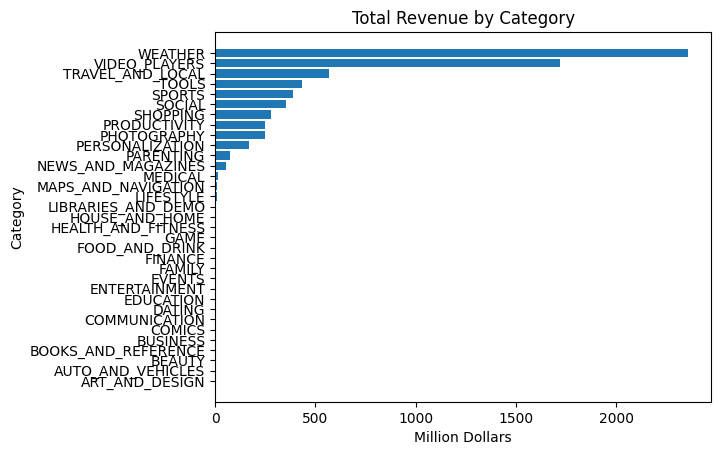

In [87]:
plt.title('Total Revenue by Category')
plt.ylabel('Category')
plt.xlabel('Million Dollars')
plt.barh(s2.index,s1_s2.values.reshape(len(s1_s2)))